# Hands On Machine Learning (Ed.2) - Chapter II

Cause currently I'm studying the awesome book of Hands On Machine Learning, I want to reproduced some examples using different libraries like plotly and structure the workflow in an easier way for me.
The data is directly from the open github and this notebook could differ in some parts with the code of the book.

All credits to Aurélien Géron. And thanks again for that wonderful book, really helpful.

--

This notebook covers:

* [0. Frame the problem](#section0)
* [1. Performance Measure](#section1)
* [2. Visualization](#section2)
* [3. Test Creation](#section3)
* [4. Correlations](#section4)
* [5. Preparing the data for the algorithm + Feature Scaling](#section5)
* [6. Select and Train the Model](#section6)
* [7. Evaluate with Test Set](#section7)
* [8. Others models and hyperparameters](#section8)

The model should learn from this data and be able to predict the median housing
price in any district, given all the other metrics.

## 0. Frame the problem <a class="anchor" id="section0"></a>

* Supervised learning task: Labeled dataset
* Regression task (multiple): The system will use multiple features to make a prediction of a value
* Univariate Regression:The model only tries to predict a single value for each district
* Plain batch Learning: No continuous flow of data and the data is small enough to fit in memory.

## 1. Performance Measure <a class="anchor" id="section1"></a>
**Root Mean Square Error(RMSE)**: Typical performance measure for regression problems. How much error the system typically makes in its predictions with a higher weight for large errors
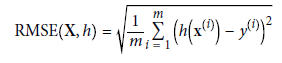

Is possible to use others performances measures like **Mean Absolute Error(MAE)** which is used in contexts with more outliers due to this measure is less sensitive to outliers than RMSE. For now we will use the RMSE

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from kaggle_tools import *

path = '../input/hands-on-machine-learning-housing-dataset/'


In [ ]:
# Read data
housing = pd.read_csv(path+'housing.csv')

### Glance to the data
* This is a small dataset: 20640 instances(rows)
* Some missing values in the column **total_bed_rooms**: 207 districs are missing the feature
* All are numerical attributes except **ocean_proximity**: This is type object

In [ ]:
print(housing.info())
housing.head()

In [ ]:
housing['ocean_proximity'].value_counts()

### Summary of each numerical attribute
* **STD:** How dispersed the values are
* **PERCENTILES:** Indicates the value below which a given percentage of observations in a group of observations falls
* * Percentile 25% in **housing_median_age**: Lower than 18 => 1st Quartile
* * Percentile 50% in **housing_median_age**: Lower than 29 => MEDIAN
* * Percentile 75% in **housing_median_age**: Lower than 37 => 3rd Quartile

In [ ]:
housing.describe()

## 2. Visualization<a class="anchor" id="section2"></a>
### Geographical Data
Take advantage of longitude and latitude attributes

In [ ]:
mapboxpath = '../input/mapbox/mapbox.txt'
px.set_mapbox_access_token(open(mapboxpath).read())

fig = px.scatter_mapbox(housing, lat="latitude", lon="longitude",     color="median_house_value", size=housing["population"],
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=4.5)

fig.update_layout(title_text="California Housing Pricing (Median)")
fig.show()

Another way to understand the data: **Histograms**
* Vertical Axis: Number of instances
* Horizontal Axis: Value Range

In [ ]:
check_num_col = housing.dtypes == 'float64'
num_col = sorted(check_num_col[check_num_col].index)
print('NUMERICAL COLUMNS: \n ', num_col)
print('HOW MANNY NUMERICAL COLUMNS? ', len(num_col))

Insights from the **histogram**
1. Median income attribute: Scale of 10k of dollars (that means, 3 actually means 30000 dollars). Also is capped at 0.4999 and 15.0001)
2. The housing_median_age and median_house_value are also capped

> Could be a problem that the attribute median_house_value was capped cause this is the target attribute. That means that the ML Algorithm may learn that prices never go beyond a limit.

If would be necessary in the future make predictions beyond $500,000 there are two main options:
* Collect more data
* Remove those districts from the training set


3. Different scales. Feature scaling will be necessary
4. Tail Heavy: They extend much farther to the right of the median than left. This distribution may make it a bit harder to detect pattern. It's easier with a bell-shaped or gaussian-shaped distributoin

In [ ]:
dfplot = housing[num_col]

fig = make_subplots(rows=3, cols=3, subplot_titles=(num_col))

index = 0
for i in range(1,4):
    for j in range(1,4):      
        data = dfplot[num_col[index]]
        trace = go.Histogram(x=data, nbinsx=50)
        fig.append_trace(trace, i, j)
        index+=1
    
fig.update_layout(height=900, width=1250, title_text="Numerical Attributes")
fig.show()

## 3. Test Set Creation<a class="anchor" id="section3"></a>
If you estimate the error of the algorithm using the train set your error estimation will be too optimistic and won't perform as expected. This is because the model could overfit the data. This fact is called *data snooping bias*

So a test set is necessary. Usually a 20% of the dataset could be use for this goal but could be less if the original dataset is huge

However, one special feature of this problem is that you *know* that the attribute median_income is very important for predict median housing prices:
* You want to ensure that the test set is representative  of the various categories of incomes in the whole dataset
* 

In [ ]:
from sklearn.model_selection import train_test_split
# Create a income category attribute
# More median income values are clustered around 1.5 to 6
# There are some median incomes beyond 6
bins_to_cut = [0., 1.5, 3.0, 4.5, 6., np.inf]
labels_to_cut = [1,2,3,4,5]
housing['income_cat'] = pd.cut(housing['median_income'], bins = bins_to_cut, labels=labels_to_cut )


fig = px.histogram(housing, x="income_cat")
fig.update_layout(height=500, width=700, title_text="Median Income Categories")
fig.show()

In [ ]:
# Split into train and test using the stratified category
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
# Check distribution in the test and train sets
print('DISTRIBUTION TRAIN SET \n', strat_train_set['income_cat'].value_counts()/len(strat_train_set))
strat_train_set.drop('income_cat', axis=1, inplace=True)
print('-----------')
print('DISTRIBUTION TEST SET \n', strat_test_set['income_cat'].value_counts()/len(strat_test_set))
strat_test_set.drop('income_cat', axis=1, inplace=True)

## 4. Check the correlations <a class="anchor" id="section4"></a>

Is important to see what attributes correlate more with the target. The correlation coefficient only measures linear correlations:
>  If X goes up, then Y goes up/down

The most promising attribute to predict the median house value is the median income.
In the next chart is possible to see that:
1. There is an upward trend and the points are not too dispersed
2. Is clearly visible that the median_income is capped at $500,000. However there are more strange lines at: 450,000 dollars; 350,000 dollars; 280,000 dollars and 112,000 dollars

In [ ]:
corr = housing.corr()
corr["median_house_value"].sort_values(ascending=False)

In [ ]:
fig = px.scatter(housing, x="median_income", y="median_house_value")
fig.show()

## 5. Prepare the data for the algorithm + Feature Scaling<a class="anchor" id="section5"></a>

Remember that
* There are some data quirkcs that should be cleaned up
* The median income has a interesting correlation with the target
* Some attributes have a tail-heavy distribution and should be reshaped into a bell-shape
* There are some attributes that they don't give us information but maybe they'll do it with some transformations


So this is the data preparation workflow
1. Create new attributes and see correlations
2. Imputer missing values for numerical attributes
3. Encode categorical attributes
4. Add a custom transformation that will work like the first point above but using hyperparamters
5. Feature Scaling


In [ ]:
# Feature Engineering
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

# Check again the correlation matrix
corr = housing.corr()
corr["median_house_value"].sort_values(ascending=False)

In [ ]:
housing = strat_train_set.drop('median_house_value', axis=1)

Separate the data for applying transformations

In [ ]:
# Numerical Attributes
housing_num = housing.drop('ocean_proximity', axis=1)
# Categorical Attributes
housing_cat = housing[['ocean_proximity']]
# Labels
housing_labels = strat_train_set['median_house_value'].copy()

### Handling Numerical Attributes

In [ ]:
# HANDLING NUMERICAL ATTRIBUTES
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
imputer.fit(housing_num)
X= imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Handling Categorical Attributes


There are two ways in order to handle this type of attributes:
1. Ordinal Encoder: Each category will be a number in the column
2. One Hot Encoder: Each category will be a column in the dataset

The Ordinal Encoder is good if the categories represents a scale of values like [good, bad, normal] because the ML algorithms will assume that two nearby values are more similar thatn two distant values

So for this case, the best choice is to use the **One Hot Encoder**


In [ ]:
# HANDLING CATEGORICAL ATTRIBUTES
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

housing_cat_encoder = encoder.fit_transform(housing_cat)
print('CATEGORIES ENCODED:\n', encoder.categories_)

### Custom Transformers

The next transformed explained in the chapter creates the next commented attributes but using hyperparameter tuning

In [ ]:
# housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
# housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
# housing["population_per_household"]=housing["population"]/housing["households"]

from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling
In general, ML Algorithms don't perform well when the input numerical data have very different scales(for example Neural Networks perform really bad in that case because they often expect an input in a range of (0,1). Example:
* The total number of rooms ranges from 6 to 39320
* The median incomes ranges from 0 to 15

> IMPORTANT: Scaling the target values is generally not required !!!

The two common ways to scaling th e data is using:
* Min-Max(Normalization): Values Shifted and rescaled in a range of (0,1)
* Standardization: Don't bound values to a specific range. However is less affected by outliers

> IMPORTANT: Fit the scalers ONLY to the Training Data. Only then you can transform the training set and test set


In order to make these transformations, is very useful to use *Transformations Pipelines*

In [ ]:
# Pipeline for numerical attributes
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

check_num_col = housing.dtypes == 'float64'
num_col = sorted(check_num_col[check_num_col].index)

pipeline_numeric = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])


In [ ]:
# Pipeline for categorical attributes
check_cat_col = housing.dtypes == 'object'
cat_col = sorted(check_cat_col[check_cat_col].index)
print('CAT COLS AFTER PROCESSED \n', cat_col)


The pipeline applies each transformer to:
* The appropiate column
* Concatenate the outputs along the second axis

So the transformer/s must return the same number of rows

In [ ]:
# Full pipeline
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('pip_num', pipeline_numeric, num_col),
    ('pip_cat', OneHotEncoder(), cat_col)
])

housing_ready = full_pipeline.fit_transform(housing)
housing_ready

## 6. Select and Train the models <a class="anchor" id="section6"></a>

It's usually for a regression problem, use as first try the LinearRegression model. This model produces an RMSE of  ~69038. So if the **median_housing_values** has a range between 120k and 265k, the error is around 69k dollars, which is very big. That could be happening cause:
* Not enough information
* The model is underfitting the data => We need a more powerful

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

def try_model(modelClass):
    model = modelClass
    model.fit(housing_ready, housing_labels)

    # Get the predictions
    predictors = housing.iloc[:5]
    labels = housing_labels.iloc[:5]

    predictors_tf = full_pipeline.transform(predictors)

    # See the predictions
    print('Predictions: \n', model.predict(predictors_tf))
    print('Labels: \n', list(labels))

    # Measure the error
    predictions_final = model.predict(housing_ready)
    rmse = np.sqrt(mean_squared_error(housing_labels, predictions_final))
    print('RMSE: ', round(rmse,2))
    
try_model(LinearRegression())

Others models to try:
* **Decision Tree Regressor:** The RMSE result is 0.0. That's because the model has overfit the data. Using the *cross_validation evaluation* we are able to see that we havce a 71k of error ±2k
* **RandomForestRegressor:** Better than the others 2, but the score on the training set is lower than in the validations set. That's meaning that the model is still overfitting the data

In [ ]:
from sklearn.tree import DecisionTreeRegressor
try_model(DecisionTreeRegressor())

### Cross-Validation Evaluation
*Use of the K-fold cross-validation feature*

The reason of using a *neg_mean_squared_error* is because cv features expect a utility function where greater is better. So scoring with CV is with the opposite of the MSE

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor


def try_with_cv(modelClass, modelname):
    print('MODEL EVALUATION ', modelname)
    
    # Use model for calculating TRAINING ERROR
    modelClass.fit(housing_ready, housing_labels)
    housing_predictions = modelClass.predict(housing_ready)
    training_error = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
    print('TRAINING ERROR: ', round(training_error,2),'\n')
    
    # Validation error using Cross Validation
    scores = cross_val_score(modelClass, housing_ready,housing_labels, scoring='neg_mean_squared_error', cv=10)
    scores_final = np.sqrt(-scores)
    
    print('VALIDATION ERROR:')
    print('RMSE(mean): ', scores_final.mean())
    print('RMSE(sd): ', scores_final.std())
    print('\n\n\n')
    
try_with_cv(DecisionTreeRegressor(), 'DECISION TREE REGRESSOR')


**Remember:** If training error < validation error => Overfitting

In [ ]:
try_with_cv(RandomForestRegressor(), 'RANDOM FOREST REGRESSOR')

### Fine-Tune the model (Grid Search)



In [ ]:
from sklearn.model_selection import GridSearchCV

# 90 rounds of training
# (3x4 + 2x3)x5
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid.fit(housing_ready, housing_labels)

In [ ]:
cvres = grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Is possible to see what attributes were the mos important for the model

## Evaluate the system on the test set<a class="anchor" id="section7"></a>
After have worked with the training set and use the evaluation set to get the errors, it's time to use the model in the test set

In [ ]:
final_model = grid.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = np.sqrt(mean_squared_error(y_test, final_predictions))
print('TEST SET MSE: ', final_mse)



In [ ]:
features_weight = grid.best_estimator_.feature_importances_
custom_att = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["pip_cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])

attributes = num_col + custom_att + cat_one_hot_attribs

sorted(zip(features_weight, attributes), reverse=True)

# Other Models with others Hyperparameters<a class="anchor" id="section8"></a>


In [ ]:
from sklearn.svm import SVR
param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]


grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_ready, housing_labels)

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
print('SUPPORT VECTOR MACHINE RMSE: ', rmse)